# The Kalman filter

\begin{align}
\mathbf{x}_{t + 1} &= \mathbf{A}\mathbf{x}_t + \mathbf{w}_t, && \text{ where } \mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}), \\
      \mathbf{y}_t &= \mathbf{C}\mathbf{x}_t + \mathbf{v}_t, && \text{ where } \mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}).
\end{align}

\begin{align}
\mathbf{m}_t^t &= \mathbf{m}_t^{t - 1} + \mathbf{K}_t (\mathbf{y}_t - \mathbf{C}\mathbf{m}_t^{t - 1})\\
\mathbf{V}_t^t &= \mathbf{V}_t^{t - 1} - \mathbf{K}_t \mathbf{C} \mathbf{V}_t^{t - 1}\\
\mathbf{K}_t &= \mathbf{V}_t^{t - 1} \mathbf{C}^\top (\mathbf{R} + \mathbf{C}\mathbf{V}_t^{t - 1}\mathbf{C}^\top)^\top
\end{align}

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [143]:
def sample_trajectory(m0, S0, A, Q, C, R, num_points):
    
    x = np.random.multivariate_normal(mean=m0, cov=S0)
    y_mean = np.dot(C, x)
    y = np.random.multivariate_normal(mean=y_mean, cov=R)
    
    xs = np.array([x])
    y_means = np.array([y_mean])
    ys = np.array([y])
    
    for i in range(num_points - 1):
        
        x = np.random.multivariate_normal(mean=np.dot(A, x), cov=Q)
        y_mean = np.dot(C, x)
        y = np.random.multivariate_normal(mean=y_mean, cov=R)
        
        xs = np.concatenate([xs[:], x[None, :]], axis=0)
        y_means = np.concatenate([y_means[:], y_mean[None, :]], axis=0)
        ys = np.concatenate([ys[:], y[None, :]], axis=0)
    
    return xs, y_means, ys

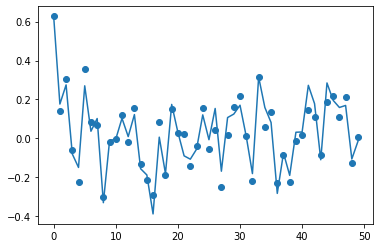

In [182]:
x_dim = 10
y_dim = 1

m0 = np.zeros(x_dim,)
S0 = 0.1 * np.eye(x_dim)

np.random.seed(0)

A = (2 * np.random.rand(x_dim, x_dim) - 1) / x_dim
Q = 0.1 ** 2 * np.eye(x_dim)

C = 2 * np.random.rand(y_dim, x_dim) - 1
R = 0.05 ** 2 * np.eye(y_dim)

num_points = 50

xs, y_means_true, ys = sample_trajectory(m0=m0, S0=S0, A=A, Q=Q, C=C, R=R, num_points=num_points)

plt.plot(np.arange(num_points), y_means_true[:, 0])
plt.scatter(np.arange(num_points), ys[:, 0])

\begin{align}
\mathbf{x}_{t + 1} &= \mathbf{A}\mathbf{x}_t + \mathbf{w}_t, && \text{ where } \mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}), \\
      \mathbf{y}_t &= \mathbf{C}\mathbf{x}_t + \mathbf{v}_t, && \text{ where } \mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}).
\end{align}

\begin{align}
\mathbf{m}_t^t &= \mathbf{m}_t^{t - 1} + \mathbf{K}_t (\mathbf{y}_t - \mathbf{C}\mathbf{m}_t^{t - 1})\\
\mathbf{V}_t^t &= \mathbf{V}_t^{t - 1} - \mathbf{K}_t \mathbf{C} \mathbf{V}_t^{t - 1}\\
\mathbf{K}_t &= \mathbf{V}_t^{t - 1} \mathbf{C}^\top (\mathbf{R} + \mathbf{C}\mathbf{V}_t^{t - 1}\mathbf{C}^\top)^\top
\end{align}

In [189]:
def forward(ys, m0, S0, A, Q, C, R):
    
    m_t_1_t = m0
    V_t_1_t = S0

    ms = []
    Vs = []
    y_means = []
    y_vars = []
    
    for t in range(num_points):
        
        y_diff = ys[t] - np.dot(C, m_t_1_t)
        m_t_t = m_t_1_t + kalman_dot(array=y_diff, V_t_1_t=V_t_1_t, C=C, R=R)
        
        KC = kalman_dot(array=C, V_t_1_t=V_t_1_t, C=C, R=R)
        V_t_t = V_t_1_t - np.dot(KC, V_t_1_t)
        
        ms.append(m_t_t)
        Vs.append(V_t_t)
        y_means.append(np.dot(C, m_t_t))
        y_vars.append(np.dot(A, np.dot(V_t_t, A.T) + V_t_t))
    
        m_t_1_t = np.dot(A, m_t_t)
        V_t_1_t = np.dot(A, np.dot(V_t_t, A.T)) + Q
        

    ms = np.array(ms)
    Vs = np.array(Vs)
    y_means = np.array(y_means)
    y_vars = np.array(y_vars)
    
    return ms, Vs, y_means, y_vars


def kalman_dot(array, V_t_1_t, C, R):
    
    R_CVCT = R + np.dot(C, np.dot(V_t_1_t, C.T))
    R_CVCT_inv_array = np.linalg.solve(R_CVCT, array)
    
    K_y = np.dot(V_t_1_t, np.dot(C, R_CVCT_inv_array))
    
    return K_y

In [190]:
ms, Vs, y_means, y_vars = forward(ys=ys, m0=m0, S0=S0, A=A, Q=Q, C=C, R=R)

t = np.arange(num_points)

plt.plot(t, y_means_true[:, 0], color='k', zorder=2)
plt.scatter(t, ys[:, 0], marker='x', color='red', zorder=3)

plt.plot(t, y_means[:, 0], '--', color='black', zorder=2)
plt.fill_between(t, y_means[:, 0] - y_vars[:, 0, 0] ** 0.5, y_means[:, 0] + y_vars[:, 0, 0] ** 0.5, color='gray', alpha=0.2, zorder=1)

(1,)


ValueError: shapes (1,10) and (1,) not aligned: 10 (dim 1) != 1 (dim 0)

In [188]:
C.shape

(1, 10)